In [1]:
import os
import gc
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import dask.array as da
import dask.dataframe as dd
sns.set_theme(style="ticks")
from scipy.stats import chi2
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.covariance import MinCovDet
from sklearn.preprocessing import StandardScaler





In [2]:
# Load segmented data
def load_segmented_data(data_folder="", event_name=None):
    """
    Load segmented CSV data.

    Parameters:
    - data_folder (str): Folder where the segmented .csv files are stored.
    - event_name (str or None): Name of the event to load. If None, loads all CSV files.

    Returns:
    - pd.DataFrame: Loaded dataframe with all data concatenated if loading all events.
    """
    if event_name is not None:
        # Load one specific event csv
        file_path = os.path.join(data_folder, f"segment_around_{event_name}.csv")
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"No data found for event '{event_name}' at {file_path}")
        df = pd.read_csv(file_path)
        print(f"Loaded data for event '{event_name}' from {file_path}.")
        return df
    else:
        # Load all csv files in the folder that match pattern 'segment_around_*.csv'
        all_files = [f for f in os.listdir(data_folder) if f.startswith("segment_around_") and f.endswith(".csv")]
        if not all_files:
            raise FileNotFoundError(f"No segmented CSV files found in folder {data_folder}")

        dfs = []
        for file in all_files:
            path = os.path.join(data_folder, file)
            df_temp = pd.read_csv(path)
            # Optionally add a column indicating source event, parsed from filename
            event_from_file = file.replace("segment_around_", "").replace(".csv", "")
            df_temp['EventName'] = event_from_file
            dfs.append(df_temp)
        df_all = pd.concat(dfs, ignore_index=True)
        print(f"Loaded and concatenated {len(all_files)} segmented event files from {data_folder}.")
        return df_all

In [3]:
# Data path
data_folder = "data/cleaned_data/data_segment"
# Load single event:
#event_name="FallingRocksEventNew"
#event_name="FogEventNew"
event_name="StagEventNew"

df_single_event = load_segmented_data(data_folder=data_folder, event_name=event_name)
df_single_event
# Load all events:
# df_all = load_segmented_data(data_folder="data/data_segment")

Loaded data for event 'StagEventNew' from data/cleaned_data/data_segment\segment_around_StagEventNew.csv.


,timestamp_REF,uid,dataset,city_section,ExperimentalCondition,UnixTimeStamp,TobiiTimeStamp,RightEyeIsBlinkingWorld,RightEyeIsBlinkingLocal,LeftEyeIsBlinkingWorld,...,ReceivedInput,TimeStamp,TimeStamp_in_sec,TimeDiff_in_sec,Blink,BlinkDuration,BlinkDurationsLong,BlinkAfter,SamplingRate,time_from_event
0,2020-09-26 13:46:22.260000+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,347.918274,False,False,False,...,1.0,1.601128e+09,139.759740,0.010971,False,0.106051,0.0,False,50.0,-5.00
1,2020-09-26 13:46:22.280000+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,347.939484,False,False,False,...,1.0,1.601128e+09,139.781682,0.021942,False,0.105959,0.0,False,50.0,-4.98
2,2020-09-26 13:46:22.300000+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,347.961914,False,False,False,...,1.0,1.601128e+09,139.803248,0.021566,False,0.105866,0.0,False,50.0,-4.96
3,2020-09-26 13:46:22.320000+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,347.983795,False,False,False,...,1.0,1.601128e+09,139.825190,0.016456,False,0.105774,0.0,False,50.0,-4.94
4,2020-09-26 13:46:22.340000+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,348.000427,False,False,False,...,1.0,1.601128e+09,139.841646,0.016705,False,0.105681,0.0,False,50.0,-4.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80155,2020-09-19 10:22:15.060000+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,MountainRoad,FullLoopAR,1.600511e+09,717.885681,False,False,True,...,1.0,1.600511e+09,170.287970,0.009973,False,NaN,0.0,False,50.0,4.92
80156,2020-09-19 10:22:15.080000+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,MountainRoad,FullLoopAR,1.600511e+09,717.907898,False,False,True,...,1.0,1.600511e+09,170.310909,0.022938,False,NaN,0.0,False,50.0,4.94
80157,2020-09-19 10:22:15.100000+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,MountainRoad,FullLoopAR,1.600511e+09,717.919006,False,False,True,...,1.0,1.600511e+09,170.322876,0.010971,False,NaN,0.0,False,50.0,4.96
80158,2020-09-19 10:22:15.120000+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,MountainRoad,FullLoopAR,1.600511e+09,717.952576,False,False,True,...,1.0,1.600511e+09,170.355788,0.022938,False,NaN,0.0,False,50.0,4.98


In [4]:
df_single_event['uid'].nunique()
df_single_event.columns

Index(['timestamp_REF', 'uid', 'dataset', 'city_section',
       'ExperimentalCondition', 'UnixTimeStamp', 'TobiiTimeStamp',
       'RightEyeIsBlinkingWorld', 'RightEyeIsBlinkingLocal',
       'LeftEyeIsBlinkingWorld', 'LeftEyeIsBlinkingLocal', 'HmdPosition.x',
       'HmdPosition.y', 'HmdPosition.z', 'NoseVector.x', 'NoseVector.y',
       'NoseVector.z', 'EyePosWorldCombined.x', 'EyePosWorldCombined.y',
       'EyePosWorldCombined.z', 'EyeDirWorldCombined.x',
       'EyeDirWorldCombined.y', 'EyeDirWorldCombined.z',
       'EyePosLocalCombined.x', 'EyePosLocalCombined.y',
       'EyePosLocalCombined.z', 'EyeDirLocalCombined.x',
       'EyeDirLocalCombined.y', 'EyeDirLocalCombined.z', 'ObjectName_1',
       'ObjectName_2', 'ObjectName_3', 'ObjectName_4', 'ObjectName_5',
       'HitObjectPosition.x_1', 'HitObjectPosition.x_2',
       'HitObjectPosition.x_3', 'HitObjectPosition.x_4',
       'HitObjectPosition.x_5', 'HitObjectPosition.y_1',
       'HitObjectPosition.y_2', 'HitObjectPositio

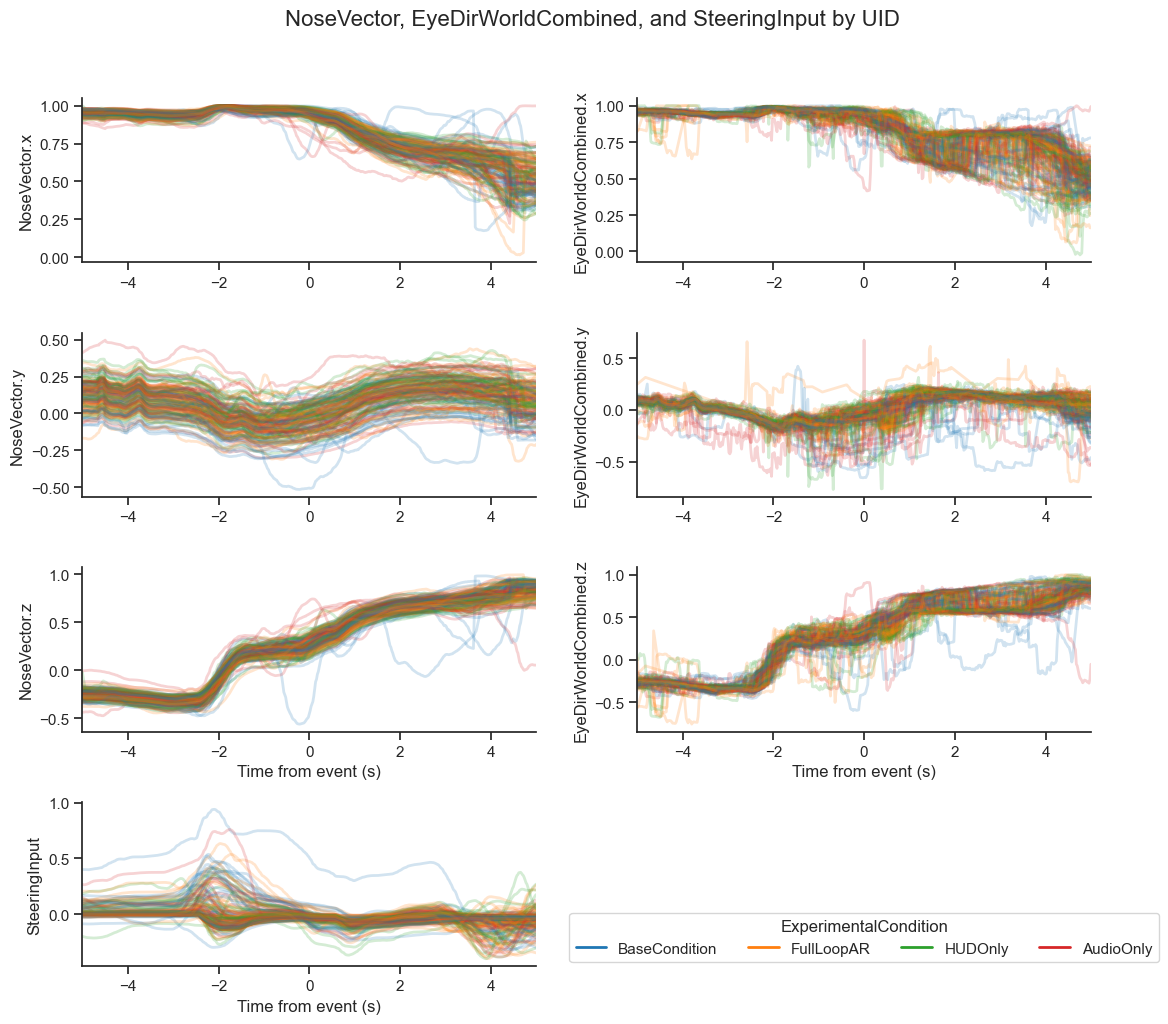

In [5]:

def plot_vectors(df, uid_col='uid'):
    """
    Plot NoseVector and EyeDirLocalCombined components in a 4x2 subplot figure,
    showing individual lines per uid, colored by ExperimentalCondition,
    despined axes with white grid and x-limits set to time_from_event range.
    The last row's left subplot is reserved for SteeringInput.
    Adds a legend indicating experimental conditions.
    """

    # Determine unique ExperimentalConditions
    conditions = df['ExperimentalCondition'].unique()

    # Assign a color to each condition
    palette = sns.color_palette("tab10", len(conditions))
    condition_color_map = dict(zip(conditions, palette))

    # Create proxy lines for the legend
    proxy_lines = [
        plt.Line2D([0], [0], color=condition_color_map[cond], linewidth=2)
        for cond in conditions
    ]

    fig, axs = plt.subplots(4, 2, figsize=(12, 11), sharex=False)
    fig.suptitle("NoseVector, EyeDirWorldCombined, and SteeringInput by UID", fontsize=16)

    unique_uids = df[uid_col].unique()

    left_cols = ['NoseVector.x', 'NoseVector.y', 'NoseVector.z']
    right_cols = ['EyeDirWorldCombined.x', 'EyeDirWorldCombined.y', 'EyeDirWorldCombined.z']

    alpha = 0.2
    linewidth = 2

    x_min = df['time_from_event'].min()
    x_max = df['time_from_event'].max()

    # Plot NoseVector and EyeDirLocalCombined (top 3 rows)
    for uid in unique_uids:
        df_uid = df[df[uid_col] == uid].sort_values('time_from_event')
        # Get the condition for this uid
        cond = df_uid['ExperimentalCondition'].iloc[0]
        line_color = condition_color_map.get(cond, 'gray')  # Default to gray if not found

        # Plot NoseVector components
        for i, col in enumerate(left_cols):
            axs[i, 0].plot(df_uid['time_from_event'], df_uid[col],
                           color=line_color, alpha=alpha, linewidth=linewidth)

        # Plot EyeDirLocalCombined components
        for i, col in enumerate(right_cols):
            axs[i, 1].plot(df_uid['time_from_event'], df_uid[col],
                           color=line_color, alpha=alpha, linewidth=linewidth)

        # Plot SteeringInput in last row, left column only
        axs[3, 0].plot(df_uid['time_from_event'], df_uid['SteeringInput'],
                       color=line_color, alpha=alpha, linewidth=linewidth)
        

    # Set labels, limits, and despine for upper 3 rows
    for i, col in enumerate(left_cols):
        ax = axs[i, 0]
        ax.set_ylabel(col)
        ax.set_xlim(x_min, x_max)
        sns.despine(ax=ax, top=True, right=True)

    for i, col in enumerate(right_cols):
        ax = axs[i, 1]
        ax.set_ylabel(col)
        ax.set_xlim(x_min, x_max)
        sns.despine(ax=ax, top=True, right=True)

    # SteeringInput axis formatting (last row, left column)
    ax_steering = axs[3, 0]
    ax_steering.set_ylabel('SteeringInput')
    ax_steering.set_xlabel('Time from event (s)')
    ax_steering.set_xlim(x_min, x_max)
    ax_steering.grid(True, color='white', linestyle='-', linewidth=2, alpha=1)
    sns.despine(ax=ax_steering, top=True, right=True)

    # Turn off unused subplot (last row, right column)
    axs[3, 1].axis('off')

    # Set x-labels for lower axes
    for ax in axs[2, :]:
        ax.set_xlabel('Time from event (s)')

    # Add legend to the figure (outside the subplots)
    # The `loc` position can be adjusted as needed
    plt.legend(proxy_lines, conditions, title='ExperimentalCondition', loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=len(conditions))

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust bottom to make space for legend
    plt.show()

# Example usage:
plot_vectors(df_single_event, uid_col='uid')

In [6]:
time_point = df_single_event[df_single_event['time_from_event']==-1.2][['NoseVector.x','EyeDirWorldCombined.x','uid','ExperimentalCondition']]
# time_point.to_csv(f"data/sample_time_negative_2s_stagEventNew.csv", index=False)
time_point.reset_index(drop=True, inplace=True)
time_point

,NoseVector.x,EyeDirWorldCombined.x,uid,ExperimentalCondition
0,0.971178,0.974988,0037b2329de444c18d751b4e79901b39,BaseCondition
1,0.978380,0.957418,0117810eb9634c4f98f842021ee6a595,FullLoopAR
2,0.981826,0.968616,0121f5b2f59d434f8beb17bf3e2a80b9,BaseCondition
3,0.969286,0.965771,0956f0cca5f546d79a0cf4fbae23d496,FullLoopAR
4,0.993546,0.948337,09a23914cf354ea39444511406d16722,BaseCondition
...,...,...,...,...
155,0.961455,0.972439,f9c6ff61370141c89ea9bbc536d796e1,FullLoopAR
156,0.979816,0.924574,fa2e2604ec6a4820851f032e80f09ba1,AudioOnly
157,0.959050,0.959365,fa4ca90c5b80445b9af0b7ec4fbcc124,BaseCondition
158,0.930346,0.970415,fd19a21a4a8846ca82bd127e4e1933f5,BaseCondition


In [7]:
time_point[['NoseVector.x','EyeDirWorldCombined.x']]

,NoseVector.x,EyeDirWorldCombined.x
0,0.971178,0.974988
1,0.978380,0.957418
2,0.981826,0.968616
3,0.969286,0.965771
4,0.993546,0.948337
...,...,...
155,0.961455,0.972439
156,0.979816,0.924574
157,0.959050,0.959365
158,0.930346,0.970415


In [8]:
scaler = StandardScaler(with_std=True)
subset_scaled = scaler.fit_transform(time_point[['NoseVector.x','EyeDirWorldCombined.x']])
df_i = pd.DataFrame(subset_scaled)
df_i

,0,1
0,-0.121462,0.526657
1,0.353916,0.103966
2,0.581347,0.373360
3,-0.246379,0.304924
4,1.354957,-0.114490
...,...,...
155,-0.763270,0.465335
156,0.448709,-0.686162
157,-0.921985,0.150811
158,-2.816644,0.416637


In [9]:

def safak_plot_confidence_ellipse(ax, mean, cov, confidence=0.99, facecolor='none', edgecolor='red', **kwargs):
    from scipy.stats import chi2
    import numpy as np
    from matplotlib.patches import Ellipse

    chi2_val = chi2.ppf(confidence, df=2)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    width, height = 2 * np.sqrt(vals * chi2_val)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      facecolor=facecolor, edgecolor=edgecolor, lw=2, **kwargs)
    ax.add_patch(ellipse)
    return ellipse
def safak_robust_mahalanobis_detection(df, feature_cols, outlier_threshold=0.01, plot=True):
    """
    Compute Mahalanobis distances using a robust covariance estimator,
    flag outliers, and optionally plot.

    Parameters:
    - df (pd.DataFrame): DataFrame with data subset
    - feature_cols (list): List of feature column names
    - outlier_threshold (float): p-value threshold for outlier cutoff
    - plot (bool): Whether to plot or not

    Returns:
    - result (pd.DataFrame): Copy of df with columns: mahalanobis_distance, outlier, p_value
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import chi2
    from sklearn.covariance import MinCovDet

    data = df[feature_cols]
    cov_estimator = MinCovDet().fit(data)
    cov = cov_estimator.covariance_
    mean = cov_estimator.location_

    inv_cov = np.linalg.pinv(cov)

    centered = data - mean

    # Optionally use dask if available or fallback to numpy
    try:
        import dask.array as da
        centered_dask = da.from_array(centered.to_numpy(), chunks=(min(centered.shape[0], 10000), centered.shape[1]))
        md_sq = da.einsum('ij,jk,ik->i', centered_dask, inv_cov, centered_dask).compute()
    except ImportError:
        md_sq = np.einsum('ij,jk,ik->i', centered.to_numpy(), inv_cov, centered.to_numpy())

    md = np.sqrt(md_sq)

    p_values = 1 - chi2.cdf(md_sq, df=len(feature_cols))

    cutoff_value = chi2.ppf(1 - outlier_threshold, df=len(feature_cols))
    outliers = md_sq > cutoff_value

    if plot:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.scatter(data.iloc[:, 0], data.iloc[:, 1], c=np.where(outliers, 'red', 'blue'), s=2, alpha=0.3, label='Inliers')
        ax.scatter(mean[0], mean[1], c='green', marker='x', s=100, label='Robust Mean')
        safak_plot_confidence_ellipse(ax, mean, cov, confidence=1 - outlier_threshold, edgecolor='orange', linestyle='--')
        ax.set_xlabel(feature_cols[0])
        ax.set_ylabel(feature_cols[1])
        ax.set_title(f'Robust Mahalanobis Outlier Detection with {outlier_threshold} threshold')
        ax.legend()
        plt.grid(True)
        plt.show()
        num_rejected = np.sum(outliers)
        print(f'Number of rejected outliers: {num_rejected}')
        
    

    result = df.copy()
    result['mahalanobis_distance'] = md
    result['outlier'] = outliers
    result['p_value'] = p_values

    return result


In [10]:

def safak_plot_confidence_ellipse(ax, mean, cov, confidence=0.99, facecolor='none', edgecolor='red', **kwargs):
    from scipy.stats import chi2
    import numpy as np
    from matplotlib.patches import Ellipse

    chi2_val = chi2.ppf(confidence, df=2)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    width, height = 2 * np.sqrt(vals * chi2_val)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      facecolor=facecolor, edgecolor=edgecolor, lw=2, **kwargs)
    ax.add_patch(ellipse)
    return ellipse

def safak_robust_mahalanobis_detection(df, feature_cols, outlier_threshold=0.01, plot=True):
    """Compute Mahalanobis distances using a robust covariance estimator, flag outliers, and plot boundary."""

    # Extract data
    data = df[feature_cols]
    # Fit MinCovDet for robust covariance and mean
    cov_estimator = MinCovDet().fit(data)
    cov = cov_estimator.covariance_
    mean = cov_estimator.location_

    # Inverse covariance matrix
    inv_cov = np.linalg.pinv(cov)

    # Compute Mahalanobis distances
    centered = data - mean
    centered_dask = da.from_array(centered.to_numpy(), chunks=(min(centered.shape[0], 10000), centered.shape[1]))
    md_sq = da.einsum('ij,jk,ik->i', centered_dask, inv_cov, centered_dask).compute()
    md = np.sqrt(md_sq)

    # Compute p-values
    p_values = 1 - chi2.cdf(md_sq, df=len(feature_cols))
    # Determine cutoff for top 1%# Determine cutoff for top percent outlier_threshold
    cutoff_value = chi2.ppf(1 - outlier_threshold, df=len(feature_cols))
    outliers = md_sq > cutoff_value

    if plot:
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(data.iloc[:, 0], data.iloc[:, 1], c=np.where(outliers, 'red', 'blue'), s=20, label='Inliers')
        ax.scatter(mean[0], mean[1], c='green', marker='x', s=100, label='Robust Mean')
        safak_plot_confidence_ellipse(ax, mean, cov, confidence=1 - outlier_threshold, edgecolor='orange', linestyle='--')
        ax.set_xlabel(feature_cols[0])
        ax.set_ylabel(feature_cols[1])
        ax.set_title(f'Robust Mahalanobis Outlier Detection with {outlier_threshold} threshold')


        # # Set fixed axis limits
        # ax.set_xlim(0.29, .95)
        # ax.set_ylim(0.39, .95)




        ax.legend()
        plt.grid(True)
        plt.show()
        num_rejected = np.sum(outliers)
        print(f'Number of rejected outliers: {num_rejected}')
        


    result = df.copy()
    result['mahalanobis_distance'] = md
    result['outlier'] = outliers
    result['p_value'] = 1 - chi2.cdf(md_sq, df=len(feature_cols))
    return result

# Set timepoint

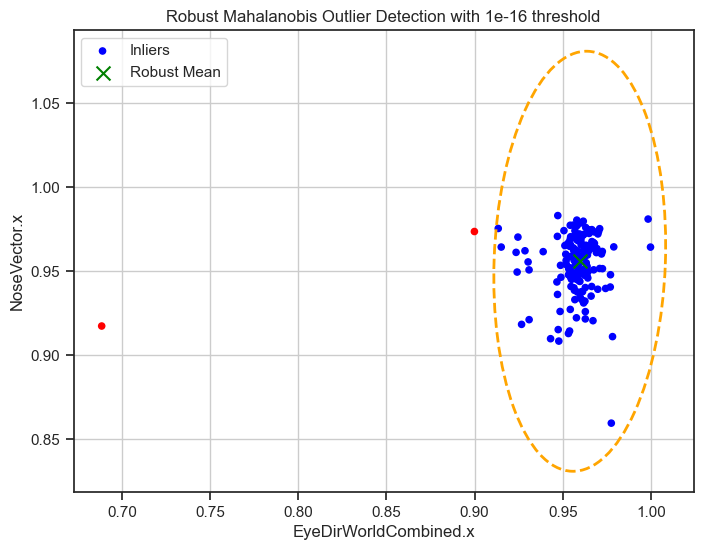

Number of rejected outliers: 2


In [11]:
time_value = -4.32

time_point = df_single_event[df_single_event['time_from_event']==time_value][['NoseVector.x','EyeDirWorldCombined.x','uid','ExperimentalCondition']]
time_point.reset_index(drop=True, inplace=True)

result_df = safak_robust_mahalanobis_detection(time_point, ['EyeDirWorldCombined.x','NoseVector.x'], outlier_threshold=1e-16)

In [12]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler

# def safak_analyze_mahalanobis_over_time(
#     df,
#     features,
#     time_col,
#     p_threshold=1e-16,
#     use_dask=True,
#     plot=True
# ):
#     """
#     Analyze Mahalanobis distances over time and detect outliers.

#     Parameters:
#     - df: pandas DataFrame containing the data
#     - features: list of feature column names to include in Mahalanobis calculation
#     - time_col: name of column indicating time points (e.g. 'time_from_event')
#     - p_threshold: p-value threshold for outlier cutoff (default 1e-16)
#     - use_dask: bool, whether to use Dask arrays if available (default True)
#     - plot: bool, whether to plot the combined results (default True)

#     Returns:
#     - summary_df: DataFrame of removed outliers count per time point
#     - distances: numpy array of all Mahalanobis distances concatenated
#     - all_outliers_mask: boolean mask array indicating outlier samples
#     """

#     import dask.array as da
#     from scipy.stats import chi2
#     from sklearn.covariance import MinCovDet

#     # Extract unique sorted time points (actual time values)
#     time_points = np.array(sorted(df[time_col].unique()))

#     # Standardize features globally to avoid scale inflation
#     scaler = StandardScaler()
#     scaled_features = scaler.fit_transform(df[features])

#     x_positions = []           # Will keep integer indices of time points per sample
#     distances = []             # Store Mahalanobis distances for all samples concatenated
#     all_outlier_indices = []   # Indices of all outlier samples in distances array
#     removed_counts = []        # List of dicts {'time_point': ..., 'removed_points': ...}

#     for t_idx, t_point in enumerate(time_points):
#         group_mask = df[time_col] == t_point
#         if not group_mask.any():
#             continue

#         group_scaled = scaled_features[group_mask]
#         group_df = df[group_mask]

#         # Robust covariance estimator
#         cov_estimator = MinCovDet().fit(group_scaled)
#         cov = cov_estimator.covariance_
#         mean = cov_estimator.location_
#         inv_cov = np.linalg.pinv(cov)

#         centered = group_scaled - mean

#         if use_dask:
#             centered_dask = da.from_array(centered, chunks=(min(centered.shape[0], 10000), centered.shape[1]))
#             md_sq = da.einsum('ij,jk,ik->i', centered_dask, inv_cov, centered_dask).compute()
#         else:
#             md_sq = np.einsum('ij,jk,ik->i', centered, inv_cov, centered)

#         md = np.sqrt(md_sq)

#         cutoff_sq = chi2.ppf(1 - p_threshold, df=len(features))
#         cutoff = np.sqrt(cutoff_sq)
#         outliers_mask = md > cutoff
#         num_outliers = np.sum(outliers_mask)
#         removed_counts.append({'time_point': t_point, 'removed_points': int(num_outliers)})

#         start_idx = len(distances)
#         distances.extend(md)
#         outlier_global_indices = np.where(outliers_mask)[0] + start_idx
#         all_outlier_indices.extend(outlier_global_indices)
#         x_positions.extend([t_idx]*len(md))

#     distances = np.array(distances)
#     x_positions = np.array(x_positions)
#     all_outliers_mask = np.zeros_like(distances, dtype=bool)
#     all_outliers_mask[all_outlier_indices] = True

#     # Map x_positions (integer indices) to actual time values
#     x_positions_actual = time_points[x_positions]

#     if plot:
#         plt.figure(figsize=(24, 10))
#         plt.scatter(x_positions_actual, distances, s=2, alpha=0.3, color='blue', label='All observations')
#         plt.scatter(x_positions_actual[all_outliers_mask], distances[all_outliers_mask], color='red', s=2, alpha=1, label='Outliers')
#         plt.xlabel('Time from event (s)')
#         plt.ylabel('Mahalanobis Distance')
#         plt.title('Distances over Time points with outliers highlighted')

#         # Set xticks spaced every 5 seconds from min to max time (adjust as needed)
#         min_time = np.floor(time_points.min())
#         max_time = np.ceil(time_points.max())
#         tick_positions = np.arange(min_time, max_time + 1, 5)
#         plt.xticks(tick_positions)

#         plt.legend()
#         plt.grid(True)
#         plt.tight_layout()
#         plt.show()

#     summary_df = pd.DataFrame(removed_counts)
#     total_removed = summary_df['removed_points'].sum()
#     total_points = len(df)
#     print(f"Total points removed: {total_removed} out of {total_points} observations over {len(summary_df)} time points.")

#     return summary_df, distances, all_outliers_mask

In [13]:
# summary_df, distances, outliers_mask = safak_analyze_mahalanobis_over_time(
#     df=df_single_event,
#     features=['NoseVector.x', 'EyeDirWorldCombined.x'],
#     time_col='time_from_event',
#     plot=True,
#     p_threshold=1e-16,
# )
# summary_dd = dd.from_pandas(summary_df, npartitions=1)
# summary_df = summary_dd.compute()

# summary_df

#1D Only using worldCombined.x for outlier

In [14]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler
# from sklearn.covariance import MinCovDet
# from scipy.stats import chi2

# def safak_analyze_mahalanobis_over_time_with_1d_mask(
#     df,
#     features,
#     time_col,
#     p_threshold=1e-16,
#     use_dask=True,
#     plot=True
# ):
#     import dask.array as da  # imported inside per your code
    
#     feature_1d = 'EyeDirWorldCombined.x'
#     time_points = np.array(sorted(df[time_col].unique()))
#     outlier_1d_mask = np.zeros(len(df), dtype=bool)

#     scaler_1d = StandardScaler()

#     for t_point in time_points:
#         group_mask = df[time_col] == t_point
#         if not group_mask.any():
#             continue

#         vals = df.loc[group_mask, feature_1d].values.reshape(-1, 1)
#         vals_scaled = scaler_1d.fit_transform(vals)

#         mcd = MinCovDet().fit(vals_scaled)
#         mean = mcd.location_[0]
#         cov = mcd.covariance_[0, 0]
#         inv_cov = 1.0 / cov

#         centered = vals_scaled - mean
#         md_sq = (centered ** 2) * inv_cov
#         md = np.sqrt(md_sq).flatten()

#         cutoff_sq = chi2.ppf(1 - p_threshold, df=1)
#         cutoff = np.sqrt(cutoff_sq)

#         outliers = md > cutoff

#         index_positions = np.where(group_mask)[0]
#         outlier_1d_mask[index_positions[outliers]] = True

#     scaler = StandardScaler()
#     scaled_features = scaler.fit_transform(df[features])

#     x_positions_indices = []
#     distances = []
#     removed_counts = []
#     all_outlier_indices = []

#     for t_idx, t_point in enumerate(time_points):
#         group_mask = df[time_col] == t_point
#         if not group_mask.any():
#             continue

#         group_scaled = scaled_features[group_mask]
#         cov_estimator = MinCovDet().fit(group_scaled)
#         cov = cov_estimator.covariance_
#         mean = cov_estimator.location_
#         inv_cov = np.linalg.pinv(cov)

#         centered = group_scaled - mean

#         if use_dask:
#             centered_dask = da.from_array(centered, chunks=(min(centered.shape[0], 10000), centered.shape[1]))
#             md_sq_2d = da.einsum('ij,jk,ik->i', centered_dask, inv_cov, centered_dask).compute()
#         else:
#             md_sq_2d = np.einsum('ij,jk,ik->i', centered, inv_cov, centered)

#         md_2d = np.sqrt(md_sq_2d)

#         cutoff_sq_2d = chi2.ppf(1 - p_threshold, df=len(features))
#         cutoff_2d = np.sqrt(cutoff_sq_2d)
#         outliers_mask_2d = md_2d > cutoff_2d
#         num_outliers_2d = np.sum(outliers_mask_2d)
#         removed_counts.append({'time_point': t_point, 'removed_points': int(num_outliers_2d)})

#         start_idx = len(distances)
#         distances.extend(md_2d)
#         outlier_global_indices = np.where(outliers_mask_2d)[0] + start_idx
#         all_outlier_indices.extend(outlier_global_indices)
#         x_positions_indices.extend([t_idx]*len(md_2d))

#     distances = np.array(distances)
#     x_positions_indices = np.array(x_positions_indices)
#     x_positions_actual = time_points[x_positions_indices]

#     if plot:
#         plt.figure(figsize=(24,10))

#         # Build aligned mask for plotting
#         all_indices_ordered = []
#         for t_idx, t_point in enumerate(time_points):
#             mask = df[time_col] == t_point
#             indices = np.where(mask)[0]
#             all_indices_ordered.extend(indices.tolist())
#         all_indices_ordered = np.array(all_indices_ordered)

#         plot_outlier_mask = outlier_1d_mask[all_indices_ordered]

#         plt.scatter(x_positions_actual, distances, s=2, alpha=0.3, color='blue', label='All observations')
#         plt.scatter(x_positions_actual[plot_outlier_mask], distances[plot_outlier_mask], color='red', s=3, alpha=1, label='1D Outliers on EyeDirWorldCombined.x')
#         plt.xlabel('Time from event (s)')
#         plt.ylabel('Mahalanobis Distance (2D)')
#         plt.title('Mahalanobis Distances over Time with 1D Feature Outliers Marked')
#         plt.xticks(np.arange(np.floor(time_points.min()), np.ceil(time_points.max()) + 1, 5))
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()

#     summary_df = pd.DataFrame(removed_counts)
#     total_removed = summary_df['removed_points'].sum()
#     total_points = len(df)
#     print(f"Total 2D outliers removed by Mahalanobis: {total_removed} out of {total_points} observations over {len(summary_df)} time points.")
#     print(f"Total 1D outliers detected on EyeDirWorldCombined.x: {outlier_1d_mask.sum()}")

#     return summary_df, distances, outlier_1d_mask


# def plot_1d_outliers_over_time(df, feature='EyeDirWorldCombined.x', time_col='time_from_event', outlier_mask=None):
#     """
#     Plot 1D feature over time colored by outlier mask.
#     """
#     if outlier_mask is None:
#         raise ValueError('Please provide outlier_mask (boolean array) aligned to df.')

#     plt.figure(figsize=(20, 6))
#     plt.scatter(df[time_col], df[feature], c=np.where(outlier_mask, 'red', 'blue'), s=2, alpha=0.3)
#     plt.xlabel('Time from event (s)')
#     plt.ylabel(feature)
#     plt.title(f'1D Feature "{feature}" with Outliers Highlighted')
#     plt.grid(True)
#     plt.show()




In [15]:
# # Example usage:
# summary_df, distances, outliers_1d_mask = safak_analyze_mahalanobis_over_time_with_1d_mask(
#     df_single_event,
#     features=['NoseVector.x', 'EyeDirWorldCombined.x'],
#     time_col='time_from_event',
#     p_threshold=1e-16,
#     plot=True,
# )

# plot_1d_outliers_over_time(
#     df_single_event,
#     feature='EyeDirWorldCombined.x',
#     time_col='time_from_event',
#     outlier_mask=outliers_1d_mask
# )

# K means plus euclidian distance

In [16]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler

# def kmeans_distance_outlier_detection(
#     df,
#     features,
#     time_col,
#     n_clusters=3,
#     distance_percentile=95
# ):
#     """
#     Detect outliers based on distance from KMeans cluster centers.

#     Parameters:
#     - df: pandas DataFrame
#     - features: list of feature column names
#     - time_col: column for time values
#     - n_clusters: number of clusters for KMeans
#     - distance_percentile: percentile threshold for outliers (e.g. 95 means top 5% distances)

#     Returns:
#     - outlier_mask: boolean array, True for points flagged as outliers
#     - summary_df: DataFrame with count of outliers per time point
#     """
#     # Standardize features globally
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(df[features])
    
#     # Fit KMeans
#     kmeans = KMeans(n_clusters=n_clusters, random_state=0)
#     labels = kmeans.fit_predict(X_scaled)
    
#     # Compute Euclidean distance to assigned cluster center
#     centers = kmeans.cluster_centers_
#     distances = np.linalg.norm(X_scaled - centers[labels], axis=1)
    
#     # Determine cutoff for outlier distances
#     cutoff = np.percentile(distances, distance_percentile)
#     outlier_mask = distances > cutoff
    
#     # Compute outliers per time point
#     time_points = sorted(df[time_col].unique())

#     removed_counts = []
    
#     for t in time_points:
#         count = np.sum(outlier_mask[df[time_col] == t])
#         removed_counts.append({'time_point': t, 'removed_points': int(count)})

#     summary_df = pd.DataFrame(removed_counts)
    
#     return outlier_mask, summary_df, distances, labels

# def plot_outliers_over_time(
#     df,
#     time_col,
#     outlier_mask,
#     distances,
#     plot_title="KMeans Distance-Based Outliers over Time"
# ):
#     """
#     Plot distances over time marking outliers in red.
#     """
#     time_points = sorted(df[time_col].unique())
#     # Map integer indices per sample based on time order

#     x_positions = []
#     for t_idx, t_point in enumerate(time_points):
#         mask = df[time_col] == t_point
#         x_positions.extend([t_idx] * np.sum(mask))
#     x_positions = np.array(x_positions)
#     distances = np.array(distances)
    
#     plt.figure(figsize=(24, 10))
#     plt.scatter(x_positions, distances, s=2, alpha=0.3, color='blue', label='All observations')
#     plt.scatter(x_positions[outlier_mask], distances[outlier_mask], color='red', s=4, alpha=1, label='Outliers')
#     plt.xlabel(f'Time point (0-{len(time_points) - 1})')
#     plt.ylabel('Distance to Cluster Center (scaled)')
#     plt.title(plot_title)
#     plt.xlim(0, len(time_points)-1)
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# # --- Usage example ---

# features = ['NoseVector.x', 'EyeDirWorldCombined.x']
# time_col = 'time_from_event'

# outlier_mask, summary_df, distances, labels = kmeans_distance_outlier_detection(
#     df_single_event,
#     features=features,
#     time_col=time_col,
#     n_clusters=3,
#     distance_percentile=99.9# adjust threshold here, e.g. 95 means top 5% farthest points
# )


# plot_outliers_over_time(
#     df_single_event,
#     time_col,
#     outlier_mask,
#     distances,
#     plot_title="KMeans + Distance Based Outliers over Time"
# )


# summary_dd = dd.from_pandas(summary_df, npartitions=1)
# summary_df = summary_dd.compute()

# summary_df

In [17]:
# def plot_outliers_for_timepoint(
#     df,
#     features,
#     time_col,
#     time_point,
#     outlier_mask,
#     title_suffix="",
#     marker_size=2
# ):
#     """
#     Plot 2D feature scatter of data **only for a specified time_point**, coloring outliers from mask.

#     Params:
#     - df: pandas DataFrame
#     - features: list of two feature names [x_feature, y_feature]
#     - time_col: time column name
#     - time_point: the time point value to filter and plot
#     - outlier_mask: boolean mask over entire df, True = outlier
#     - title_suffix: optional string to append to plot title
#     - marker_size: scatter marker size
#     """
#     mask_time = df[time_col] == time_point
#     if not mask_time.any():
#         print(f"No data points for time point {time_point}")
#         return

#     data_time = df.loc[mask_time]
#     mask_outliers_time = outlier_mask[mask_time]

#     plt.figure(figsize=(8, 6))
#     plt.scatter(
#         data_time.loc[~mask_outliers_time, features[0]],
#         data_time.loc[~mask_outliers_time, features[1]],
#         color='blue',
#         s=marker_size,
#         label='Inliers'
#     )
#     plt.scatter(
#         data_time.loc[mask_outliers_time, features[0]],
#         data_time.loc[mask_outliers_time, features[1]],
#         color='red',
#         s=marker_size,
#         label='Outliers'
#     )

#     plt.xlabel(features[0])
#     plt.ylabel(features[1])
#     plt.title(f"Outliers at {time_col}={time_point} {title_suffix}")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

In [18]:
# # Using the KMeans mask from before (or any boolean mask you got)
# plot_outliers_for_timepoint(
#     df_single_event,
#     features=['NoseVector.x', 'EyeDirWorldCombined.x'],
#     time_col='time_from_event',
#     time_point=4.72,
#     outlier_mask=outlier_mask,  # your boolean mask from detection
#     title_suffix="(KMeans distance outliers)"
# )

# Using DBSCAN

# single feature

In [19]:
# def dbscan_outlier_detection_per_timepoint(
#     df,
#     features,
#     time_col,
#     eps=1.7,
#     min_samples=7
# ):
#     """
#     Run DBSCAN clustering separately on each time point's data,
#     flag outliers (noise) per time slice, and combine results.

#     Parameters:
#     - df: pandas DataFrame
#     - features: list of features to cluster by
#     - time_col: column name for time points
#     - eps: DBSCAN eps parameter (radius)
#     - min_samples: DBSCAN min_samples parameter

#     Returns:
#     - outlier_mask: boolean array of length df, True for outliers
#     - summary_df: DataFrame counting outliers per time point
#     - labels_all: concatenated cluster labels (noise = -1) for all points
#     """
#     time_points = np.array(sorted(df[time_col].unique()))
#     outlier_mask = np.zeros(len(df), dtype=bool)
#     labels_all = np.full(len(df), -2, dtype=int)  # Initialize with placeholder
#     removed_counts = []

#     scaler = StandardScaler()

#     for t_point in time_points:
#         mask = df[time_col] == t_point
#         idxs = np.where(mask)[0]
#         if len(idxs) == 0:
#             continue

#         data_subset = df.loc[mask, features].values
#         # Scale only this time point's data
#         if len(data_subset) > 1:  # DBSCAN needs at least 2 samples
#             data_scaled = scaler.fit_transform(data_subset)

#             db = DBSCAN(eps=eps, min_samples=min_samples)
#             labels = db.fit_predict(data_scaled)
#         else:
#             labels = np.array([0])  # Single point: label as cluster 0

#         # Mark noise points as outliers
#         noise_mask = labels == -1
#         outlier_mask[idxs[noise_mask]] = True
#         labels_all[idxs] = labels

#         removed_counts.append({'time_point': t_point, 'removed_points': int(noise_mask.sum())})

#     summary_df = pd.DataFrame(removed_counts)
#     return outlier_mask, summary_df, labels_all

# # Plotting function to visualize over time with outliers marked

# def plot_outliers_over_time_mask(df, time_col, outlier_mask, title="DBSCAN outliers per time point"):
#     time_points = sorted(df[time_col].unique())
#     x_positions = []
#     for t_idx, t_point in enumerate(time_points):
#         mask = df[time_col] == t_point
#         x_positions.extend([t_idx] * np.sum(mask))
#     x_positions = np.array(x_positions)

#     plt.figure(figsize=(24, 10))
#     plt.scatter(x_positions, np.zeros_like(x_positions), s=3, alpha=0.3, color='blue', label='All points')
#     plt.scatter(x_positions[outlier_mask], np.zeros_like(x_positions[outlier_mask]), s=6, color='red', label='Outliers')
#     plt.xlabel(f'Time point (0-{len(time_points)-1})')
#     plt.title(title)
#     plt.yticks([])  # hide y-axis since it's dummy
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# def plot_dbscan_outliers_feature_over_time(df, feature, time_col, outlier_mask):
#     """
#     Plot 1D feature over time colored by outlier mask.
#     """
#     plt.figure(figsize=(20, 6))
#     plt.scatter(df[time_col], df[feature], c=np.where(outlier_mask, 'red', 'blue'), s=3, alpha=0.3)
#     plt.xlabel('Time from event (s)')
#     plt.ylabel(feature)
#     plt.title(f'{feature} over time with DBSCAN outliers marked')
#     plt.grid(True)
#     plt.show()


# def plot_dbscan_outliers_single_timepoint(df, features, time_col, time_point, labels_all):
#     """
#     Plot points at a specified timepoint, highlighting DBSCAN outliers.

#     Parameters:
#         df (pd.DataFrame): Full data.
#         features (list): Two features for scatter plot.
#         time_col (str): Name of the time column.
#         time_point (float or int): Time point to plot.
#         labels_all (np.array): Concatenated DBSCAN labels for all samples (-1 means outlier).
#     """
#     mask = df[time_col] == time_point
#     if not mask.any():
#         print(f"No data for time point {time_point}")
#         return

#     data_tp = df.loc[mask]
    
#     # Important: labels_all is full length; indices in mask correspond to df indices in order
#     # So get labels for only those time point samples
#     indices = np.where(mask)[0]
#     labels_tp = labels_all[indices]

#     inliers = labels_tp != -1
#     outliers = labels_tp == -1

#     plt.figure(figsize=(8, 6))
#     plt.scatter(
#         data_tp.loc[inliers, features[0]],
#         data_tp.loc[inliers, features[1]],
#         c='blue', s=30, label='Inliers'
#     )
#     plt.scatter(
#         data_tp.loc[outliers, features[0]],
#         data_tp.loc[outliers, features[1]],
#         c='red', s=50, label='Outliers'
#     )
#     plt.xlabel(features[0])
#     plt.ylabel(features[1])
#     plt.title(f'DBSCAN Outliers at {time_col} = {time_point}')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     # Assuming you have these variables from your per-timepoint DBSCAN function:
# # outlier_mask, summary_df, labels_all





# # Features used for DBSCAN detection (only 1D)
# dbscan_features = ['EyeDirWorldCombined.x']  

# # Features used for 2D plotting of single time point
# plot_features = ['EyeDirWorldCombined.x', 'NoseVector.x']

# time_col = 'time_from_event'

# eps = 1.7  # DBSCAN eps parameter, tune carefully

# # Run DBSCAN per time point only on 1D feature
# outlier_mask, summary_df, labels_all = dbscan_outlier_detection_per_timepoint(
#     df_single_event,
#     features=dbscan_features,
#     time_col=time_col,
#     eps=1.7,  # tune carefully
#     min_samples=7
# )


# # Plot 1D feature over time, mark outliers
# plot_dbscan_outliers_feature_over_time(df_single_event, dbscan_features[0], time_col, outlier_mask)

# # Plot 2D scatter at one time point using both features, colored by outlier detection based on 1D
# plot_dbscan_outliers_single_timepoint(
#     df_single_event,
#     features=plot_features,  # plot in 2D for visualization
#     time_col=time_col,
#     time_point=time_value,  # set your desired time point here
#     labels_all=labels_all   # labels from 1D DBSCAN to mark outliers
# )

# import os

# def save_dbscan_plots_per_timepoint(
#     df, features, time_col, labels_all, output_dir='1_feature_dbscan_timepoint_plots'
# ):
#     os.makedirs(output_dir, exist_ok=True)
#     time_points = sorted(df[time_col].unique())

#     for t_point in time_points:
#         mask = df[time_col] == t_point
#         if not mask.any():
#             continue

#         data_tp = df.loc[mask]
#         indices = np.where(mask)[0]
#         labels_tp = labels_all[indices]

#         inliers = labels_tp != -1
#         outliers = labels_tp == -1

#         plt.figure(figsize=(8, 6))
#         plt.scatter(
#             data_tp.loc[inliers, features[0]], 
#             data_tp.loc[inliers, features[1]], 
#             c='blue', s=30, label='Inliers'
#         )
#         plt.scatter(
#             data_tp.loc[outliers, features[0]], 
#             data_tp.loc[outliers, features[1]], 
#             c='red', s=50, label='Outliers'
#         )
#         plt.xlabel(features[0])
#         plt.ylabel(features[1])
#         plt.title(f"DBSCAN Outliers at {time_col} = {t_point}")
#         plt.legend()
#         plt.grid(True)
#         filename = os.path.join(output_dir, f"dbscan_outliers_{time_col}_{t_point:06.2f}.png")
#         plt.savefig(filename)
#         plt.close()
#         print(f"Saved plot for time point {t_point} to {filename}")

# #Usage example (assuming you ran dbscan and have `labels_all`):


# # save_dbscan_plots_per_timepoint(
# #     df_single_event,
# #     features= plot_features,
# #     time_col='time_from_event',
# #     labels_all=labels_all,
# #     output_dir = f'1_feature_dbscan_timepoint_plots_eps={eps:.2f}')


# summary_df  # Outlier counts per time point


# n features

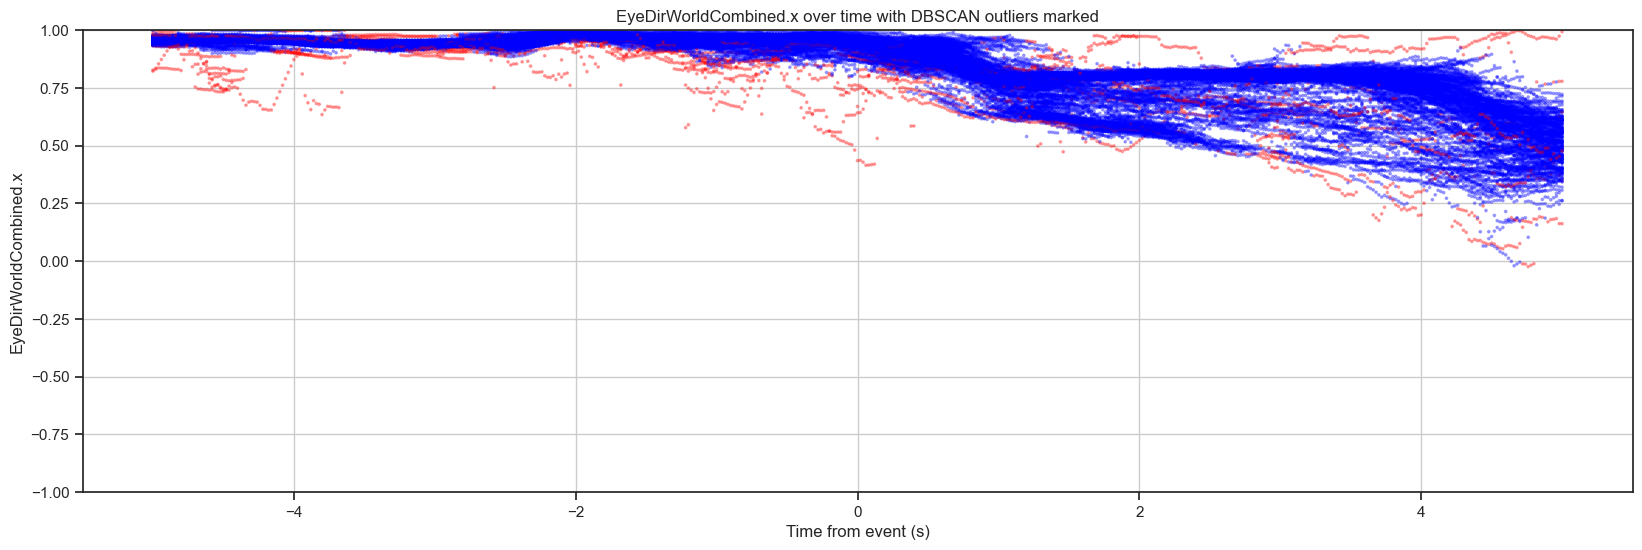

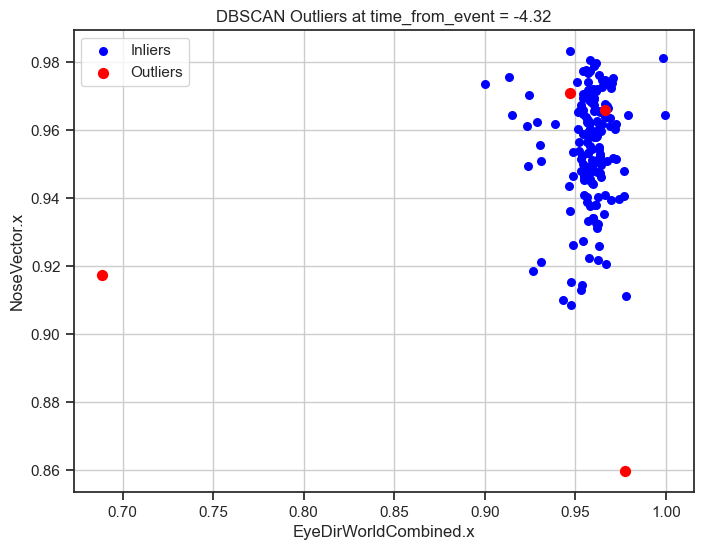

,time_point,removed_points
0,-5.00,8
1,-4.98,8
2,-4.96,8
3,-4.94,8
4,-4.92,9
...,...,...
496,4.92,5
497,4.94,6
498,4.96,5
499,4.98,7


In [20]:
def dbscan_outlier_detection_per_timepoint(
    df,
    features,
    time_col,
    eps=1.7,
    min_samples=7
):
    """
    Run DBSCAN clustering separately on each time point's data,
    flag outliers (noise) per time slice, and combine results.

    Parameters:
    - df: pandas DataFrame
    - features: list of features to cluster by
    - time_col: column name for time points
    - eps: DBSCAN eps parameter (radius)
    - min_samples: DBSCAN min_samples parameter

    Returns:
    - outlier_mask: boolean array of length df, True for outliers
    - summary_df: DataFrame counting outliers per time point
    - labels_all: concatenated cluster labels (noise = -1) for all points
    """
    time_points = np.array(sorted(df[time_col].unique()))
    outlier_mask = np.zeros(len(df), dtype=bool)
    labels_all = np.full(len(df), -2, dtype=int)  # Initialize with placeholder
    removed_counts = []

    scaler = StandardScaler()

    for t_point in time_points:
        mask = df[time_col] == t_point
        idxs = np.where(mask)[0]
        if len(idxs) == 0:
            continue

        data_subset = df.loc[mask, features].values
        # Scale only this time point's data
        if len(data_subset) > 1:  # DBSCAN needs at least 2 samples
            data_scaled = scaler.fit_transform(data_subset)

            db = DBSCAN(eps=eps, min_samples=min_samples)
            labels = db.fit_predict(data_scaled)
        else:
            labels = np.array([0])  # Single point: label as cluster 0

        # Mark noise points as outliers
        noise_mask = labels == -1
        outlier_mask[idxs[noise_mask]] = True
        labels_all[idxs] = labels

        removed_counts.append({'time_point': t_point, 'removed_points': int(noise_mask.sum())})

    summary_df = pd.DataFrame(removed_counts)

    # Add outlier column for downstream use
    df = df.copy()
    df['outlier'] = outlier_mask

    return outlier_mask, summary_df, labels_all, df

# Plotting function to visualize over time with outliers marked

def plot_outliers_over_time_mask(df, time_col, outlier_mask, title="DBSCAN outliers per time point"):
    time_points = sorted(df[time_col].unique())
    x_positions = []
    for t_idx, t_point in enumerate(time_points):
        mask = df[time_col] == t_point
        x_positions.extend([t_idx] * np.sum(mask))
    x_positions = np.array(x_positions)

    plt.figure(figsize=(24, 10))
    plt.scatter(x_positions, np.zeros_like(x_positions), s=3, alpha=0.3, color='blue', label='All points')
    plt.scatter(x_positions[outlier_mask], np.zeros_like(x_positions[outlier_mask]), s=6, color='red', label='Outliers')
    plt.xlabel(f'Time point (0-{len(time_points)-1})')
    plt.title(title)
    plt.yticks([])  # hide y-axis since it's dummy
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_dbscan_outliers_feature_over_time(df, feature, time_col, outlier_mask, ylim=(-1, 1)):
    """
    Plot 1D feature over time colored by outlier mask.

    Parameters:
    - df: pandas DataFrame
    - feature: name of the feature to plot
    - time_col: name of the time column
    - outlier_mask: boolean mask for outliers (True=outlier, False=normal)
    - ylim: tuple, y-axis limits (default (-1, 1))
    """
    plt.figure(figsize=(20, 6))
    plt.scatter(df[time_col], df[feature], c=np.where(outlier_mask, 'red', 'blue'), s=3, alpha=0.3)
    plt.xlabel('Time from event (s)')
    plt.ylabel(feature)
    plt.title(f'{feature} over time with DBSCAN outliers marked')
    plt.ylim(ylim)  # Set y-axis limits here
    plt.grid(True)
    plt.show()

def plot_dbscan_outliers_single_timepoint(df, features, time_col, time_point, labels_all):
    """
    Plot points at a specified timepoint, highlighting DBSCAN outliers.

    Parameters:
        df (pd.DataFrame): Full data.
        features (list): Two features for scatter plot.
        time_col (str): Name of the time column.
        time_point (float or int): Time point to plot.
        labels_all (np.array): Concatenated DBSCAN labels for all samples (-1 means outlier).
    """
    mask = df[time_col] == time_point
    if not mask.any():
        print(f"No data for time point {time_point}")
        return

    data_tp = df.loc[mask]
    
    # Important: labels_all is full length; indices in mask correspond to df indices in order
    # So get labels for only those time point samples
    indices = np.where(mask)[0]
    labels_tp = labels_all[indices]

    inliers = labels_tp != -1
    outliers = labels_tp == -1

    plt.figure(figsize=(8, 6))
    plt.scatter(
        data_tp.loc[inliers, features[0]],
        data_tp.loc[inliers, features[1]],
        c='blue', s=30, label='Inliers'
    )
    plt.scatter(
        data_tp.loc[outliers, features[0]],
        data_tp.loc[outliers, features[1]],
        c='red', s=50, label='Outliers'
    )
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title(f'DBSCAN Outliers at {time_col} = {time_point}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Assuming you have these variables from your per-timepoint DBSCAN function:
# outlier_mask, summary_df, labels_all





# Features used for DBSCAN detection (THIS TIME 2D)
dbscan_features = ['EyeDirWorldCombined.x', 'NoseVector.x', 'EyeDirWorldCombined.y' ,  'NoseVector.y' ]#,'SteeringInput']#, 'EyeDirWorldCombined.z','NoseVector.z'

# Features used for 2D plotting of single time point
plot_features = ['EyeDirWorldCombined.x','NoseVector.x'] # 'NoseVector.x']

time_col = 'time_from_event'

eps = 1.7  # Tune this parameter carefully based on your data distribution


# Run DBSCAN per time point on 2D feature
outlier_mask, summary_df, labels_all, df_with_outliers = dbscan_outlier_detection_per_timepoint(
    df_single_event,
    features=dbscan_features,
    time_col='time_from_event',
    eps=eps,
    min_samples=7
)


# Plot 1D feature over time, mark outliers
plot_dbscan_outliers_feature_over_time(df_single_event, dbscan_features[0], time_col, outlier_mask)

# Plot 2D scatter at one time point using both features, colored by outlier detection based on 1D
plot_dbscan_outliers_single_timepoint(
    df_single_event,
    features=plot_features,  # plot in 2D for visualization
    time_col=time_col,
    time_point=time_value,  # set your desired time point here
    labels_all=labels_all   # labels from 1D DBSCAN to mark outliers
)

import os

def save_dbscan_plots_per_timepoint(
    df, features, time_col, labels_all, output_dir='2_feature_dbscan_timepoint_plots'
):
    os.makedirs(output_dir, exist_ok=True)
    time_points = sorted(df[time_col].unique())

    for t_point in time_points:
        mask = df[time_col] == t_point
        if not mask.any():
            continue

        data_tp = df.loc[mask]
        indices = np.where(mask)[0]
        labels_tp = labels_all[indices]

        inliers = labels_tp != -1
        outliers = labels_tp == -1

        plt.figure(figsize=(8, 6))
        plt.scatter(
            data_tp.loc[inliers, features[0]], 
            data_tp.loc[inliers, features[1]], 
            c='blue', s=30, label='Inliers'
        )
        plt.scatter(
            data_tp.loc[outliers, features[0]], 
            data_tp.loc[outliers, features[1]], 
            c='red', s=50, label='Outliers'
        )
        plt.xlabel(features[0])
        plt.ylabel(features[1])
        plt.title(f"DBSCAN Outliers at {time_col} = {t_point}")
        plt.legend()
        plt.grid(True)
        filename = os.path.join(output_dir, f"dbscan_outliers_{time_col}_{t_point:06.2f}.png")
        plt.savefig(filename)
        plt.close()
        print(f"Saved plot for time point {t_point} to {filename}")

# Usage example (assuming you ran dbscan and have `labels_all`):

# save_dbscan_plots_per_timepoint(
#     df_single_event,
#     features= plot_features,
#     time_col='time_from_event',
#     labels_all=labels_all,
#     output_dir = f'2_feature_dbscan_timepoint_plots_eps={eps:.2f}')



summary_df  # Outlier counts per time point





In [21]:
#helper function: 
def find_outlier_runs(outlier_flags):
    """
    Given a boolean 1D array indicating outliers,
    return arrays of start and end indices of consecutive True runs.
    """
    # Find where outlier flag changes (True->False or False->True)
    changes = np.diff(outlier_flags.astype(int))
    split_indices = np.where(changes != 0)[0] + 1
    
    # Add start and end of array to split positions
    starts = np.insert(split_indices, 0, 0)
    ends = np.append(split_indices, len(outlier_flags))
    
    # Return only runs where outlier_flags[start] is True (valid consecutive outlier runs)
    run_starts = []
    run_ends = []
    for s, e in zip(starts, ends):
        if outlier_flags[s]:
            run_starts.append(s)
            run_ends.append(e)
    return np.array(run_starts), np.array(run_ends)

Total points removed (outliers): 3826
Average points removed per time point: 7.64
Global outlier count from mask: 3826


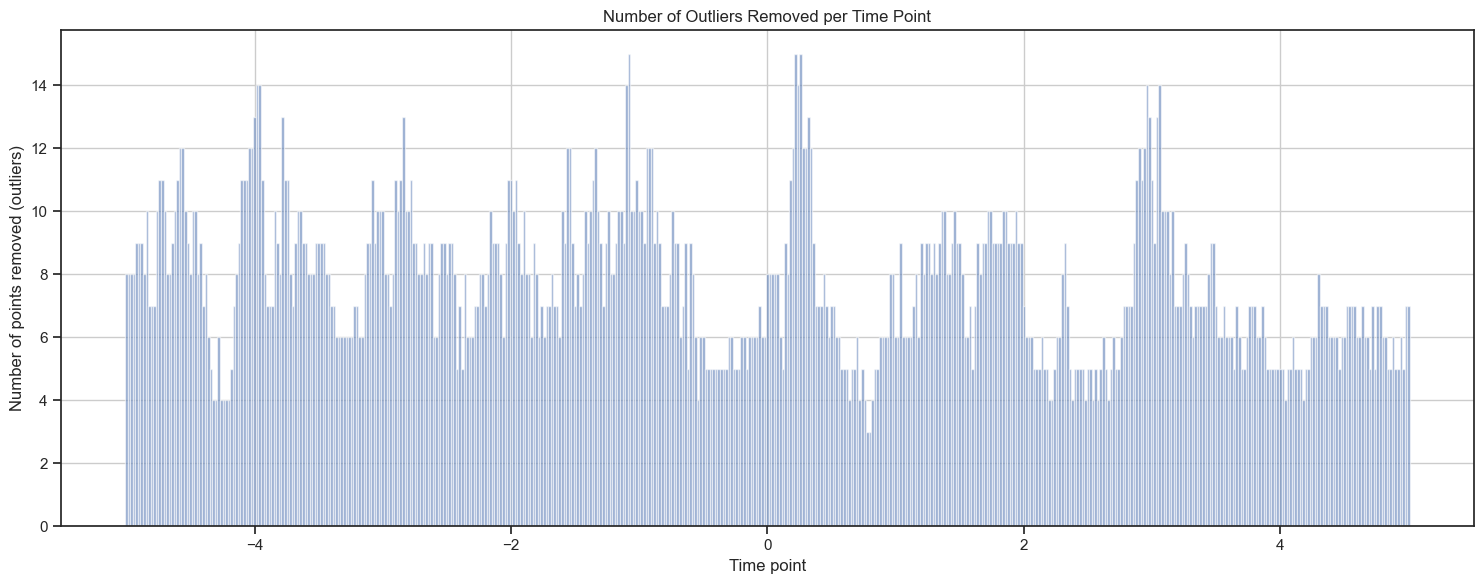

                                uid  duration_ms  num_points
0  0121f5b2f59d434f8beb17bf3e2a80b9           40           2
1  0121f5b2f59d434f8beb17bf3e2a80b9           40           2
2  0956f0cca5f546d79a0cf4fbae23d496          220          11
3  09a23914cf354ea39444511406d16722          200          10
4  09a23914cf354ea39444511406d16722           20           1


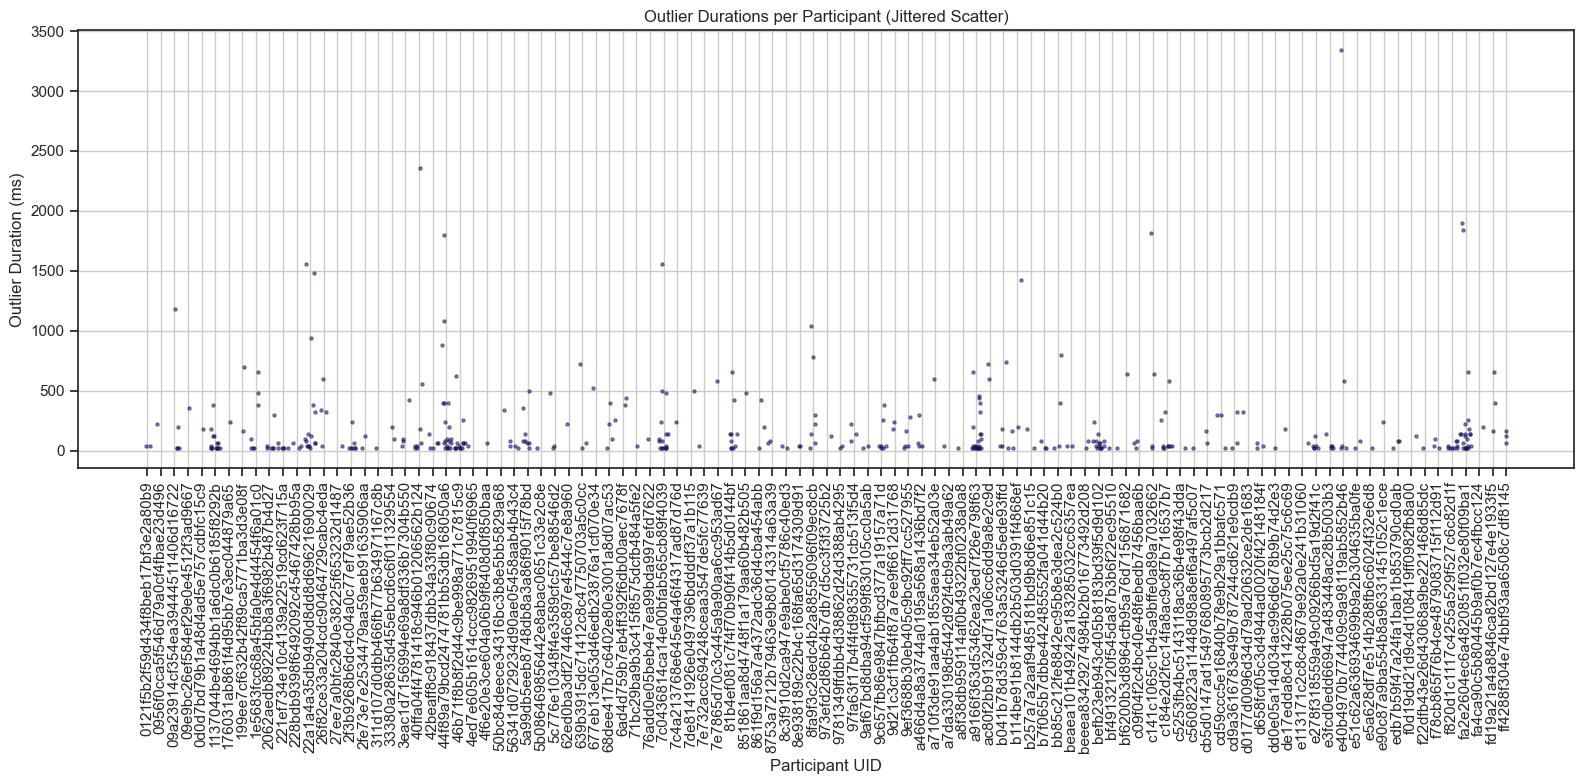

,uid,duration_ms,num_points
0,e40b4970b774409c9a98119ab5852b46,3340,167
1,40ffa04f4781418c946b01206562b124,2360,118
2,fa2e2604ec6a4820851f032e80f09ba1,1900,95
3,fa2e2604ec6a4820851f032e80f09ba1,1840,92
4,c141c1065c1b45a9bffe0a89a7032662,1820,91
...,...,...,...
399,639b3915dc71412c8c47750703a5c0cc,20,1
400,68dee417b7c6402e80e3001a8d07ac53,20,1
401,befb23eb943c405b8183bd39f5d9d102,20,1
402,7c0436814ca14e00bfab565cb89f4039,20,1


In [22]:

# Print total and average counts
total_removed = summary_df['removed_points'].sum()
average_removed = summary_df['removed_points'].mean()

print(f"Total points removed (outliers): {total_removed}")
print(f"Average points removed per time point: {average_removed:.2f}")

if 'outlier_mask' in globals():
    print(f"Global outlier count from mask: {outlier_mask.sum()}")

# Plot removed points per time point
plt.figure(figsize=(15, 6))
plt.bar(summary_df['time_point'], summary_df['removed_points'], width=0.02, alpha=0.6)
plt.xlabel('Time point')
plt.ylabel('Number of points removed (outliers)')
plt.title('Number of Outliers Removed per Time Point')
plt.grid(True)
plt.tight_layout()
plt.show()

def count_consecutive_outlier_durations(df, uid_col='uid', outlier_col='outlier', ms_per_sample=20):
    durations = []
    df_sorted = df.sort_values([uid_col, 'time_from_event']).copy()
    
    for uid, group in df_sorted.groupby(uid_col):
        outliers = group[outlier_col].values
        
        run_starts, run_ends = find_outlier_runs(outliers)
        
        for start, end in zip(run_starts, run_ends):
            run_length = end - start
            durations.append({
                uid_col: uid,
                'duration_ms': run_length * ms_per_sample,
                'num_points': run_length
            })
    durations_df = pd.DataFrame(durations)
    return durations_df

durations_df = count_consecutive_outlier_durations(
    df_with_outliers,
    uid_col='uid',
    outlier_col='outlier',
    ms_per_sample=20
)

print(durations_df.head())


# Get all unique UIDs from your original dataframe, sorted
all_uids = sorted(df_single_event['uid'].unique())

# Create a mapping from uid to x positions (numeric)
uid_to_xpos = {uid: i for i, uid in enumerate(all_uids)}

# Map UIDs in durations_summary to x positions
x_positions = durations_df['uid'].map(uid_to_xpos)

# plt.figure(figsize=(20, 8))

# plt.scatter(
#     x_positions,
#     durations_summary['duration'],
#     alpha=0.7,
#     s=50,
#     color='blue',
#     edgecolor='k'
# )


plt.figure(figsize=(16, 8))

# Map UID to a numeric x position
uids = durations_df['uid'].unique()
uid_to_num = {uid: i for i, uid in enumerate(uids)}

# Numeric x positions (without jitter)
x_pos = durations_df['uid'].map(uid_to_num)

# Add horizontal jitter (+/- 0.2)
jitter = np.random.uniform(-0.4, 0.4, size=len(durations_df))

plt.scatter(x_pos + jitter, durations_df['duration_ms'],
            alpha=0.5, s=5, color='blue', edgecolor='k')

plt.xticks(ticks=range(len(uids)), labels=uids, rotation=90)
plt.xlabel('Participant UID')
plt.ylabel('Outlier Duration (ms)')
plt.title('Outlier Durations per Participant (Jittered Scatter)')
plt.tight_layout()
plt.grid(True)
plt.show()

durations_summary = durations_df.round(3)
durations_summarys_sorted = durations_summary.sort_values('duration_ms', ascending=False).reset_index(drop=True)
durations_summarys_sorted  # Show top 20 longest outlier runs

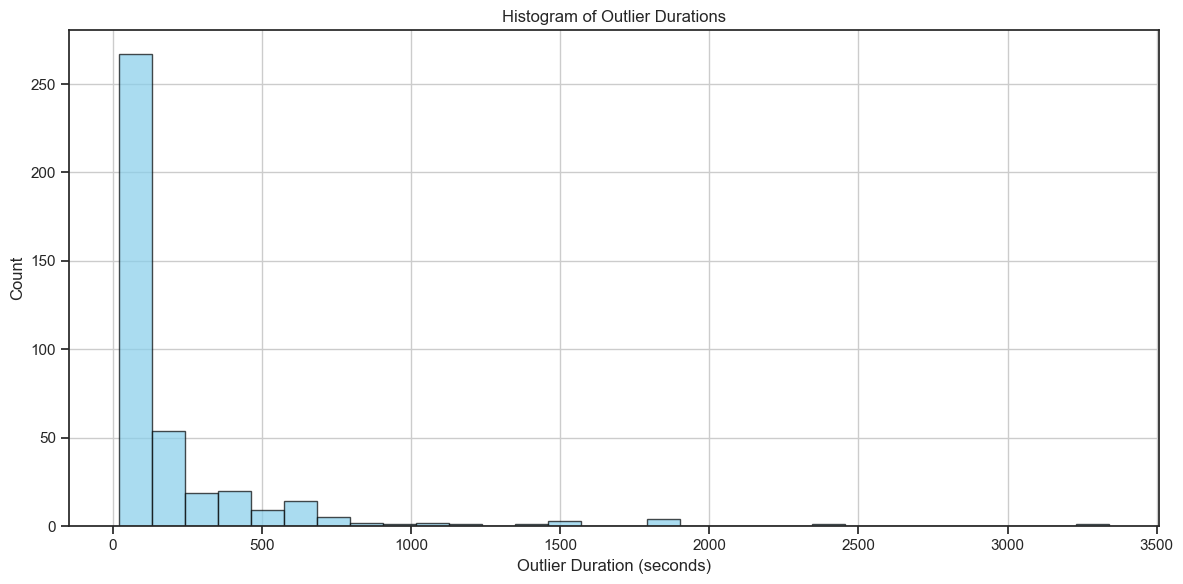

In [23]:
plt.figure(figsize=(12, 6))
plt.hist(durations_df['duration_ms'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Outlier Duration (seconds)')
plt.ylabel('Count')
plt.title('Histogram of Outlier Durations')
plt.grid(True)
plt.tight_layout()
plt.show()

# Interpolate outliers

interpolate between prev and next values

In [24]:

# def interpolate_and_summarize_outliers(
#     df, 
#     uid_col='uid', 
#     outlier_col='outlier', 
#     interp_cols=None,
#     time_col=None
# ):
#     """
#     For each uid, replace outlier rows with NaN in specified columns,
#     count consecutive NaN runs (outlier segments), record lengths,
#     and linearly interpolate NaNs within each run using adjacent valid values.

#     Parameters:
#         df (pd.DataFrame): input data with outlier flags
#         uid_col (str): participant id column name
#         outlier_col (str): boolean outlier flag column name
#         interp_cols (list of str): columns to interpolate
#         time_col (str, optional): if provided, sort by uid and time before processing

#     Returns:
#         df_filled : pd.DataFrame with interpolated values replacing outliers
#         summary_df : pd.DataFrame with columns [uid, start_idx, end_idx, length]
#             Each row is one consecutive outlier segment (NaN run)
#     """
#     if interp_cols is None:
#         raise ValueError("Please specify interp_cols")

#     # Make copy to avoid modifying original
#     df_filled = df.copy()

#     # Sort by uid and optionally by time
#     if time_col:
#         df_filled = df_filled.sort_values([uid_col, time_col]).reset_index(drop=True)
#     else:
#         df_filled = df_filled.sort_values(uid_col).reset_index(drop=True)

#     segments = []

#     # Process per user
#     for uid, group in df_filled.groupby(uid_col):
#         indices = group.index.values
#         outliers = group[outlier_col].values

#         # Mark columns as NaN where outlier == True
#         for col in interp_cols:
#             mask = (df_filled.index.isin(indices[outliers]))
#             df_filled.loc[mask, col] = np.nan

#         # Detect consecutive NaN runs per column (same for all specified columns)
#         is_nan = df_filled.loc[indices, interp_cols[0]].isna().values  # use first col for mask

#         # Find breaks in is_nan (True/False changes)
#         changes = np.diff(is_nan.astype(int))
#         run_starts = np.where(changes == 1)[0] + 1
#         run_ends = np.where(changes == -1)[0] + 1

#         # Handle cases where run starts at index 0 or ends at last index
#         if is_nan[0]:
#             run_starts = np.insert(run_starts, 0, 0)
#         if is_nan[-1]:
#             run_ends = np.append(run_ends, len(is_nan))

#         # Collect run info and fill via interpolation
#         for start, end in zip(run_starts, run_ends):
#             run_indices = indices[start:end]

#             length = len(run_indices)
#             segments.append({
#                 uid_col: uid,
#                 'start_idx': run_indices[0],
#                 'end_idx': run_indices[-1],
#                 'length': length
#             })

#             # For each column, do linear interpolation within this run limits
#             for col in interp_cols:
#                 # Get previous value before run
#                 prev_idx = run_indices[0] - 1
#                 # Get next value after run
#                 next_idx = run_indices[-1] + 1

#                 if (prev_idx in df_filled.index) and (next_idx in df_filled.index):
#                     start_val = df_filled.at[prev_idx, col]
#                     end_val = df_filled.at[next_idx, col]

#                     # Create linear space between start_val and end_val of size run length + 2, then exclude first and last
#                     interpolated_vals = np.linspace(start_val, end_val, length + 2)[1:-1]
#                     df_filled.loc[run_indices, col] = interpolated_vals
#                 elif prev_idx in df_filled.index:
#                     # forward fill
#                     fill_val = df_filled.at[prev_idx, col]
#                     df_filled.loc[run_indices, col] = fill_val
#                 elif next_idx in df_filled.index:
#                     # backward fill
#                     fill_val = df_filled.at[next_idx, col]
#                     df_filled.loc[run_indices, col] = fill_val
#                 else:
#                     # no boundary values, leave as is (NaN)
#                     pass

#     summary_df = pd.DataFrame(segments)
#     return df_filled, summary_df

In [25]:
# interp_cols = ['EyeDirWorldCombined.x', 'NoseVector.x']

# df_linear_int, outlier_segments = interpolate_and_summarize_outliers(
#     df_with_outliers,
#     uid_col='uid',
#     time_col='time_from_event',
#     outlier_col='outlier',
#     interp_cols=interp_cols
# )

# print(outlier_segments.head())
# print(df_linear_int.head())
# outlier_lengths_sorted = outlier_segments.sort_values('length', ascending=False).reset_index(drop=True)
# outlier_lengths_sorted  # Show top 20 longest outlier runs

In [26]:
# # Features used for DBSCAN detection (THIS TIME 2D)
# dbscan_features = ['EyeDirWorldCombined.x', 'NoseVector.x']

# # Features used for 2D plotting of single time point
# plot_features = ['EyeDirWorldCombined.x', 'NoseVector.x']

# time_col = 'time_from_event'

# eps = 1.7  # Tune this parameter carefully based on your data distribution


# # 1. Run detection + plotting on raw data
# outlier_mask_raw, summary_df_raw, labels_all_raw, _ = dbscan_outlier_detection_per_timepoint(
#     df_single_event,
#     features=dbscan_features,
#     time_col='time_from_event',
#     eps=eps,
#     min_samples=7
# )

# plot_dbscan_outliers_feature_over_time(df_single_event, dbscan_features[0], time_col, outlier_mask_raw)
# plot_dbscan_outliers_single_timepoint(
#     df_single_event,
#     features=plot_features,
#     time_col=time_col,
#     time_point=time_value,
#     labels_all=labels_all_raw
# )

# # 2. Run detection + plotting on interpolated data
# outlier_mask_interp, summary_df_interp, labels_all_interp, df_linear_int = dbscan_outlier_detection_per_timepoint(
#     df_linear_int,
#     features=dbscan_features,
#     time_col='time_from_event',
#     eps=eps,
#     min_samples=7
# )

# plot_dbscan_outliers_feature_over_time(df_linear_int, dbscan_features[0], time_col, outlier_mask_interp)
# plot_dbscan_outliers_single_timepoint(
#     df_linear_int,
#     features=plot_features,
#     time_col=time_col,
#     time_point=time_value,
#     labels_all=labels_all_interp
# )


# summary_df  # Outlier counts per time point





single participant

In [27]:
# participant_uid = '0037b2329de444c18d751b4e79901b39'

# # Filter original and interpolated data for that UID
# df_single_event_sub = df_single_event[df_single_event['uid'] == participant_uid].copy()
# df_interpolated_sub = df_interpolated[df_interpolated['uid'] == participant_uid].copy()

# # 1. Run detection + plotting on raw data for this participant only
# outlier_mask_raw, summary_df_raw, labels_all_raw, _ = dbscan_outlier_detection_per_timepoint(
#     df_single_event_sub,
#     features=dbscan_features,
#     time_col='time_from_event',
#     eps=eps,
#     min_samples=7
# )

# plot_dbscan_outliers_feature_over_time(df_single_event_sub, dbscan_features[0], time_col, outlier_mask_raw)

# # Pick a suitable time point to plot for this participant
# time_value = df_single_event_sub[time_col].iloc[0]  # or a specific time you want
# plot_dbscan_outliers_single_timepoint(
#     df_single_event_sub,
#     features=plot_features,
#     time_col=time_col,
#     time_point=time_value,
#     labels_all=labels_all_raw
# )

# # 2. Run detection + plotting on interpolated data for this participant only
# outlier_mask_interp, summary_df_interp, labels_all_interp, _ = dbscan_outlier_detection_per_timepoint(
#     df_interpolated_sub,
#     features=dbscan_features,
#     time_col='time_from_event',
#     eps=eps,
#     min_samples=7
# )

# plot_dbscan_outliers_feature_over_time(df_interpolated_sub, dbscan_features[0], time_col, outlier_mask_interp)

# plot_dbscan_outliers_single_timepoint(
#     df_interpolated_sub,
#     features=plot_features,
#     time_col=time_col,
#     time_point=time_value,
#     labels_all=labels_all_interp
# )

# # Optionally print summaries just for this participant
# print("Raw summary:")
# print(summary_df_raw)
# print("\nInterpolated summary:")
# print(summary_df_interp)

replace with nearest neighbor

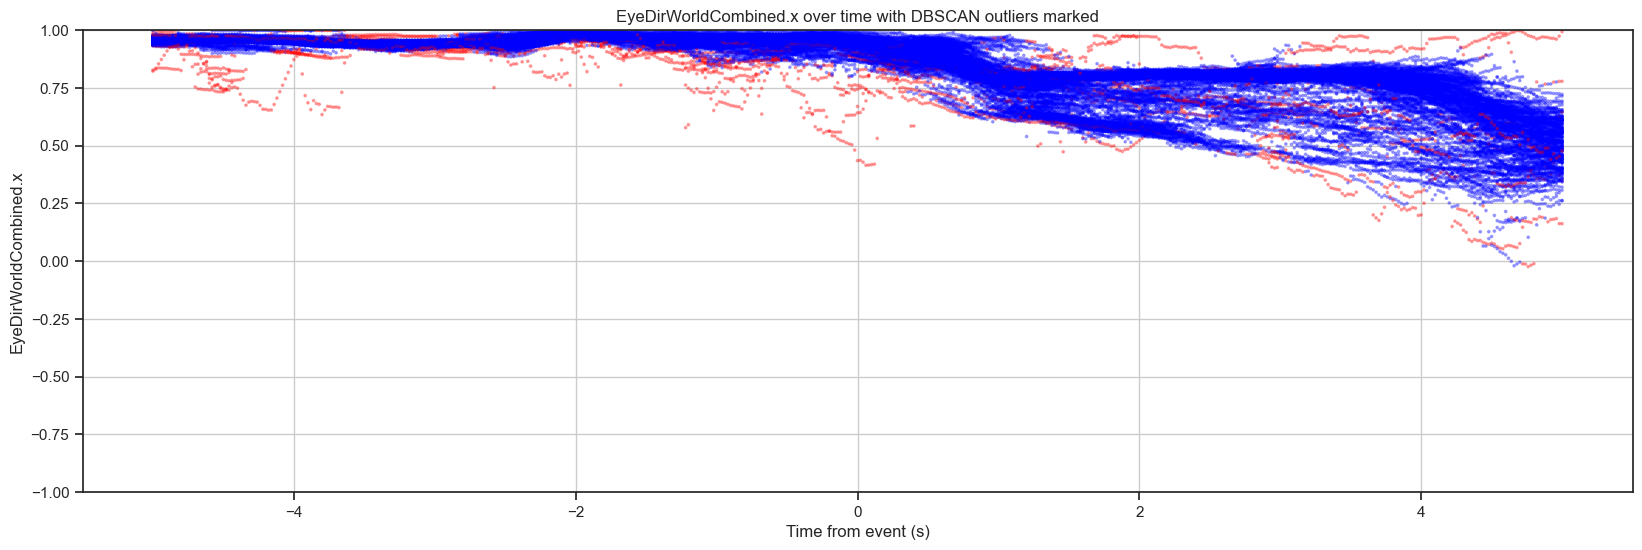

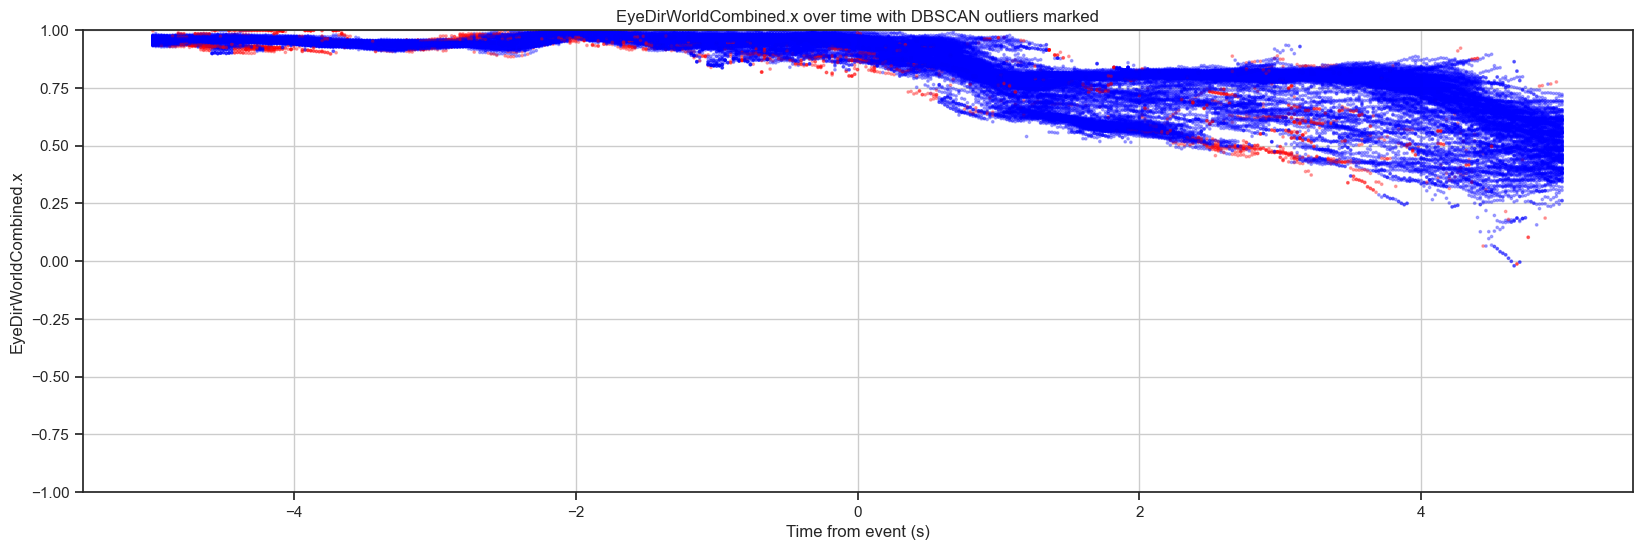

DBSCAN results before fix at time=-4.32


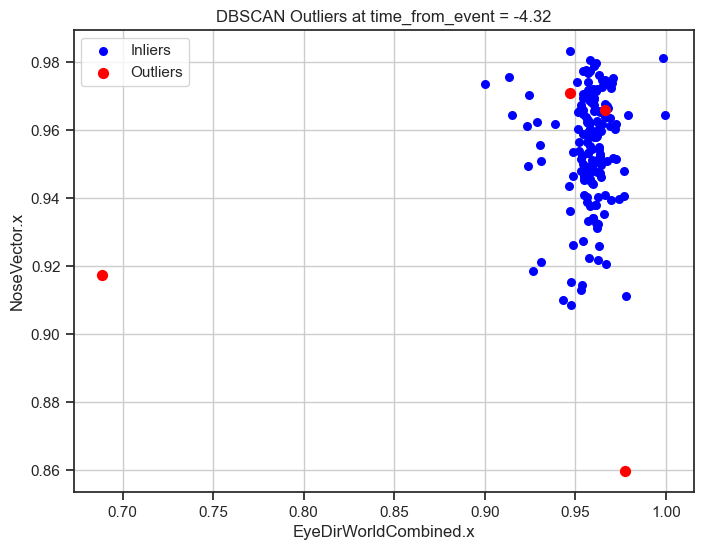

DBSCAN results after fix at time=-4.32


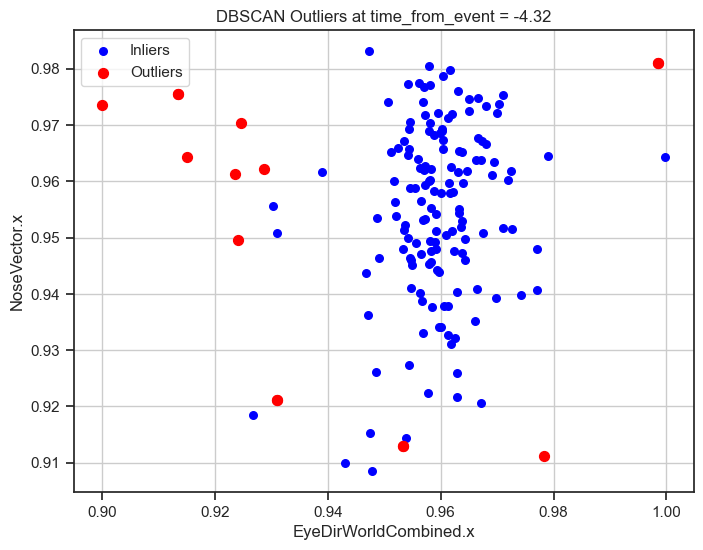

In [28]:
from scipy.spatial import cKDTree

def replace_outliers_nearest_neighbor(df, features, time_col='time_from_event', outlier_col='outlier'):
    df = df.copy()
    
    for t_point in df[time_col].unique():
        mask = df[time_col] == t_point
        df_tp = df.loc[mask]
        
        if df_tp.empty:
            continue
        
        outlier_mask = df_tp[outlier_col].values
        non_outlier_mask = ~outlier_mask
        
        if non_outlier_mask.sum() == 0:
            # No good points to copy from, optionally skip or handle differently
            continue
        
        # Features of non-outliers (reference points)
        non_outlier_features = df_tp.loc[non_outlier_mask, features].values
        
        # Features of outliers
        outlier_features = df_tp.loc[outlier_mask, features].values
        
        # Build a KD-tree on non-outliers features for fast nearest neighbor search
        tree = cKDTree(non_outlier_features)
        
        # Find nearest neighbor indices in non-outliers for each outlier point
        dist, idx = tree.query(outlier_features, k=1)
        
        # Replace outlier points features with nearest non-outlier features
        outlier_indices_in_df = df_tp.index[outlier_mask]
        nearest_features = non_outlier_features[idx]
        
        df.loc[outlier_indices_in_df, features] = nearest_features
    
    return df

# Assuming you already have these from earlier:
# dbscan_features = ['EyeDirWorldCombined.x', 'NoseVector.x']
# time_col = 'time_from_event'
# df_single_event: your original DataFrame

# 1. Run DBSCAN on original data
outlier_mask_pre, summary_df_pre, labels_all_pre, df_with_outliers = dbscan_outlier_detection_per_timepoint(
    df_single_event,
    features=dbscan_features,
    time_col=time_col,
    eps=1.7,
    min_samples=7
)

# Plot DBSCAN outliers feature over time BEFORE fixing
plot_dbscan_outliers_feature_over_time(
    df_single_event, 
    feature=dbscan_features[0], 
    time_col=time_col, 
    outlier_mask=outlier_mask_pre
)

# 2. Fix outliers by nearest non-outlier neighbor (function from previous cell)
df_nearest_neighbor = replace_outliers_nearest_neighbor(
    df_with_outliers,  # contains 'outlier' column
    features=dbscan_features,
    time_col=time_col,
    outlier_col='outlier'
)

# 3. Run DBSCAN again on fixed DataFrame
outlier_mask_post, summary_df_post, labels_all_post, _ = dbscan_outlier_detection_per_timepoint(
    df_nearest_neighbor,
    features=dbscan_features,
    time_col=time_col,
    eps=1.7,
    min_samples=7
)

# Plot DBSCAN outliers feature over time AFTER fixing
plot_dbscan_outliers_feature_over_time(
    df_nearest_neighbor,
    feature=dbscan_features[0],
    time_col=time_col,
    outlier_mask=outlier_mask_post
)

# Optional: plot single timepoint comparison (e.g., at t=0.5)


time_value= -4.32



time_point_to_plot = time_value

print(f"DBSCAN results before fix at time={time_point_to_plot}")
plot_dbscan_outliers_single_timepoint(
    df_single_event,
    features=dbscan_features,
    time_col=time_col,
    time_point=time_point_to_plot,
    labels_all=labels_all_pre
)

print(f"DBSCAN results after fix at time={time_point_to_plot}")
plot_dbscan_outliers_single_timepoint(
    df_nearest_neighbor,
    features=dbscan_features,
    time_col=time_col,
    time_point=time_point_to_plot,
    labels_all=labels_all_post
)

# Adjust outliers to group mean 

In [29]:
# def replace_outliers_with_group_mean(df, features, time_col='time_from_event', outlier_col='outlier'):
#     """
#     Replace outlier feature values with the mean value of the non-outlier points
#     at the same time point.

#     Parameters:
#         df: pd.DataFrame containing data and outlier flags
#         features: list of feature column names to replace
#         time_col: column indicating time points
#         outlier_col: boolean column indicating outliers

#     Returns:
#         df_copy: pd.DataFrame with outliers replaced by group means at respective time points
#     """
#     df_copy = df.copy()

#     # Group non-outliers by time and calculate mean per feature
#     group_means = df_copy.loc[~df_copy[outlier_col]].groupby(time_col)[features].mean()

#     # For each time point, replace outlier values with group mean
#     for t_point, means in group_means.iterrows():
#         mask = (df_copy[time_col] == t_point) & (df_copy[outlier_col])
#         if mask.any():
#             df_copy.loc[mask, features] = means.values

#     return df_copy

In [30]:

# # 1. Run DBSCAN on original data
# outlier_mask_pre, summary_df_pre, labels_all_pre, df_with_outliers = dbscan_outlier_detection_per_timepoint(
#     df_single_event,
#     features=dbscan_features,
#     time_col=time_col,
#     eps=1.7,
#     min_samples=7
# )

# # Plot DBSCAN outliers feature over time BEFORE fixing
# plot_dbscan_outliers_feature_over_time(
#     df_single_event, 
#     feature=dbscan_features[0], 
#     time_col=time_col, 
#     outlier_mask=outlier_mask_pre
# )

# df_fixed = replace_outliers_with_group_mean(
#     df_with_outliers,  # DataFrame with 'outlier' column
#     features=dbscan_features,
#     time_col=time_col,
#     outlier_col='outlier'
# )

# # 3. Run DBSCAN again on fixed DataFrame
# outlier_mask_post, summary_df_post, labels_all_post, _ = dbscan_outlier_detection_per_timepoint(
#     df_group_mean,
#     features=dbscan_features,
#     time_col=time_col,
#     eps=1.7,
#     min_samples=7
# )

# # Plot DBSCAN outliers feature over time AFTER fixing
# plot_dbscan_outliers_feature_over_time(
#     df_group_mean,
#     feature=dbscan_features[0],
#     time_col=time_col,
#     outlier_mask=outlier_mask_post
# )

# # Optional: plot single timepoint comparison (e.g., at t=0.5)


# time_value= -4.32



# time_point_to_plot = time_value

# print(f"DBSCAN results before fix at time={time_point_to_plot}")
# plot_dbscan_outliers_single_timepoint(
#     df_single_event,
#     features=dbscan_features,
#     time_col=time_col,
#     time_point=time_point_to_plot,
#     labels_all=labels_all_pre
# )

# print(f"DBSCAN results after fix at time={time_point_to_plot}")
# plot_dbscan_outliers_single_timepoint(
#     df_fixed,
#     features=dbscan_features,
#     time_col=time_col,
#     time_point=time_point_to_plot,
#     labels_all=labels_all_post
# )

# save 

In [31]:
import os

# DBSCAN features
feature_count = len(dbscan_features)

# Get DataFrame to save
df_dict = {
    'nearest_neighbor': df_nearest_neighbor,
    # 'group_mean': df_group_mean,
    # 'linear_int': df_linear_int
}
alg = 'nearest_neighbor'
df_to_save = df_dict[alg]

# New subdirectory that includes the feature count
output_subdir = f"outliers_removed_{feature_count}features"
output_dir = os.path.join(data_folder, output_subdir)
os.makedirs(output_dir, exist_ok=True)

# File naming
original_filename = f"segment_around_{event_name}.csv"
base_name, ext = os.path.splitext(original_filename)
new_filename = f"{base_name}_{alg}{ext}"

# Full save path
output_path = os.path.join(output_dir, new_filename)

# Save
df_to_save.to_csv(output_path, index=False)
print(f"Saved processed data with outliers removed at:\n{output_path}")


Saved processed data with outliers removed at:
data/cleaned_data/data_segment\outliers_removed_4features\segment_around_StagEventNew_nearest_neighbor.csv


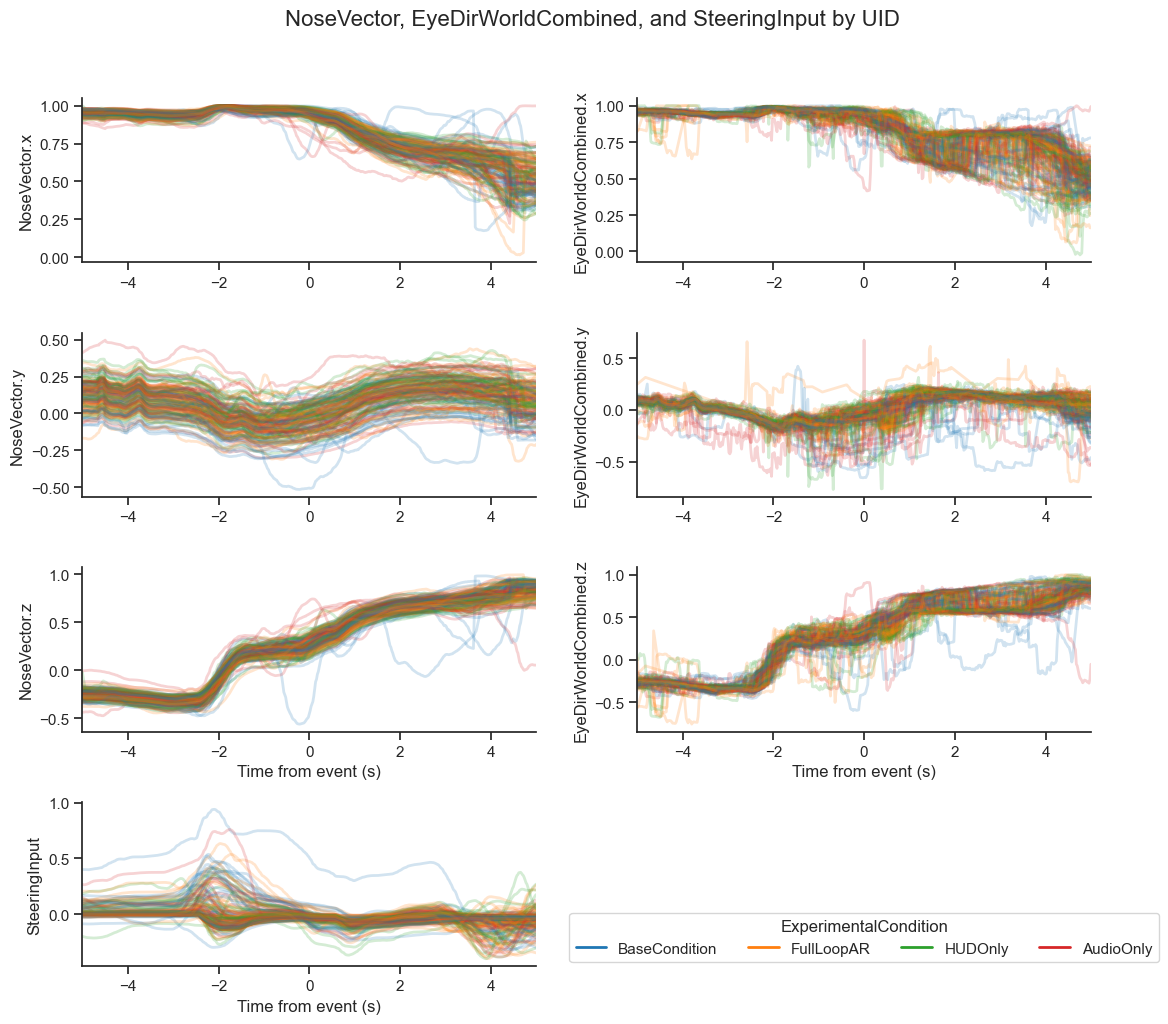

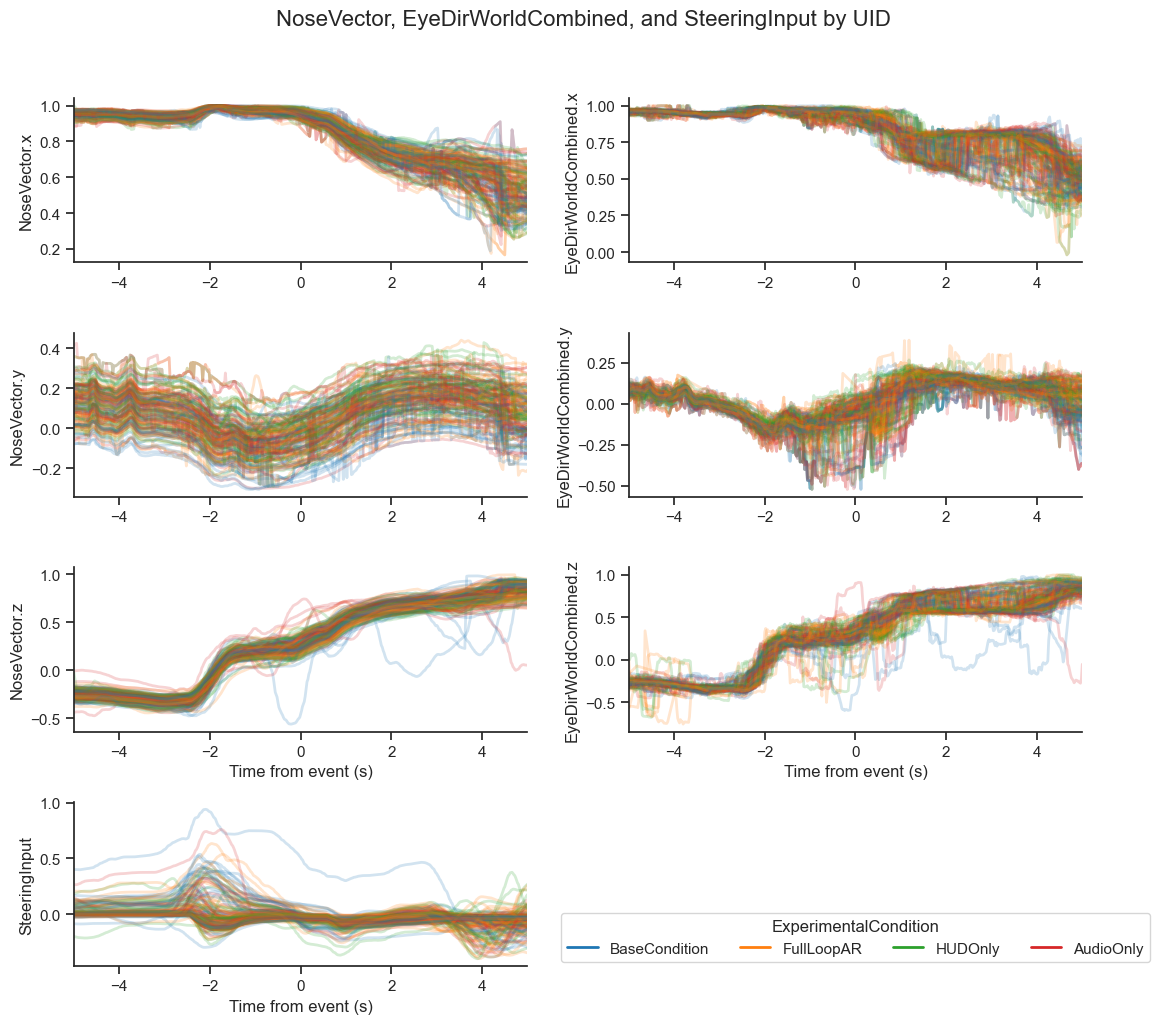

In [32]:
# Example usage:
plot_vectors(df_single_event, uid_col='uid')

plot_vectors(df_to_save, uid_col='uid')